## 빅데이터 활용 AI 설계
# AutoEncoder : Cifar-10 적용

In [0]:
import numpy as np
import matplotlib.pyplot as plt

### Cifar-10 로딩

In [2]:
from keras.datasets import cifar10

(X_train, y_train), (_, _) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


In [3]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((50000, 32, 32, 3), dtype('uint8'), 255, 0)

In [4]:
display(y_train.shape, y_train[:10])

(50000, 1)

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [0]:
X_train = X_train[y_train.ravel()==1]/255 # 자동차

In [6]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((5000, 32, 32, 3), dtype('float64'), 1.0, 0.0)

### 흑백사진으로 변환

In [0]:
X_train = X_train.mean(axis=-1)[:,:,:,np.newaxis]

In [8]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((5000, 32, 32, 1), dtype('float64'), 1.0, 0.0)

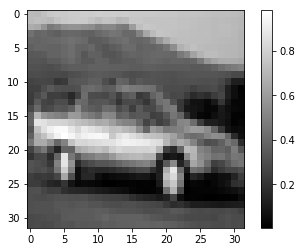

In [9]:
plt.imshow(X_train[0,:,:,0], cmap='gray') # 32*32*1 이므로 채널값을 0으로 놓음
plt.colorbar()

### 인코더 생성

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose

In [11]:
input = Input((32,32,1))

x = Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(input)
x = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(x)

x = Flatten()(x)
latent = Dense(10)(x)

W0829 23:58:23.800564 139853073024896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 23:58:23.844767 139853073024896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 23:58:23.854745 139853073024896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



- 인코더의 출력은 10개의 벡터값이다.
- 이 값을 잠재공간벡터(latent vector) 라고 한다.
- 즉, 28\*28\*1 의 이미지를 10개의 숫자로 축약하였다.

In [12]:
encoder = Model(input, latent)

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
_____________________________________________________

### 디코더 생성

In [0]:
input2 = Input((10,))

x2 = Dense(4*4*128, activation='relu')(input2)
x2 = Reshape((4,4,128))(x2)

x2 = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x2)
x2 = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x2)

output = Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='relu')(x2)

In [14]:
decoder = Model(input2, output)

decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              22528     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 1)         289       
Total params: 115,073
Trainable params: 115,073
Non-trainable params: 0
_____________________________________________________

### 오토인코더 구성

In [15]:
autoencoder = Model(input, decoder(encoder(input)))

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 10)                113162    
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 1)         115073    
Total params: 228,235
Trainable params: 228,235
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

W0829 23:58:39.205592 139853073024896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
autoencoder.fit(X_train, X_train, batch_size=32, epochs=100, validation_split=0.1)

W0829 23:58:49.606267 139853073024896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0829 23:58:49.613355 139853073024896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 8s 2ms/step - loss: 0.0880 - acc: 0.0106 - val_loss: 0.0776 - val_acc: 0.0059
Epoch 2/100
4500/4500 [==============================] - 1s 309us/step - loss: 0.0464 - acc: 0.0138 - val_loss: 0.0335 - val_acc: 0.0130
Epoch 3/100
4500/4500 [==============================] - 1s 311us/step - loss: 0.0362 - acc: 0.0150 - val_loss: 0.0361 - val_acc: 0.0128
Epoch 4/100
4500/4500 [==============================] - 1s 311us/step - loss: 0.0321 - acc: 0.0152 - val_loss: 0.0409 - val_acc: 0.0127
Epoch 5/100
4500/4500 [==============================] - 1s 313us/step - loss: 0.0285 - acc: 0.0153 - val_loss: 0.0325 - val_acc: 0.0131
Epoch 6/100
4500/4500 [==============================] - 1s 312us/step - loss: 0.0267 - acc: 0.0154 - val_loss: 0.0397 - val_acc: 0.0126
Epoch 7/100
4500/4500 [==============================] - 1s 311us/step - loss: 0.0256 - acc: 0.0154 - val_loss: 0.0287 - val_acc: 0.0

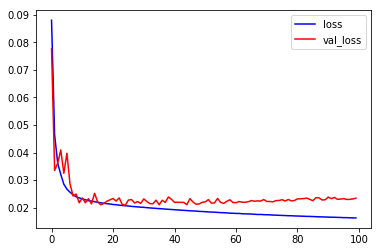

In [18]:
h = autoencoder.history.history

plt.plot(h['loss'], 'b-')
plt.plot(h['val_loss'], 'r-')
plt.legend(['loss', 'val_loss'])

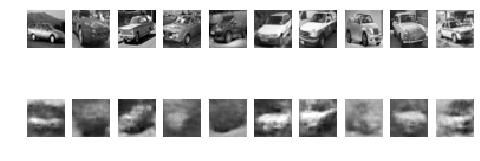

In [19]:
plt.figure(figsize=[8,3])

for i in range(10):
    r = autoencoder.predict(X_train[[i]])

    plt.subplot(2,10,1+i)
    plt.imshow(X_train[i,:,:,0], vmax=1, vmin=0, cmap='gray')
    plt.axis('off')

    plt.subplot(2,10,11+i)
    plt.imshow(r[0,:,:,0], vmax=1, vmin=0, cmap='gray')
    plt.axis('off')